In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Learning Simulations
These are my notes for going through the excercises in the neuronal dynamics textbook.


In [3]:
# Import brian
from brian2 import *
# data frame support and `tidy` plotting
import pandas as pd
import numpy as np
# ggplot port to python
from plotnine import *
#activate inline use of matplotlib
%matplotlib inline

Define a very simple neuron with this syntax.
The text in the apostrophe environment are the differential equations that define the behaviour.


In [4]:
tau = 10*ms             # a time constant
eqs = '''
dv/dt = (1-v)/tau : 1
'''

Now we can put the equation into a neuron.
The equation formally typed out:
\begin{equation}
\frac{\partial v}{\partial t} = \frac{(1-v)}{\tau}
\end{equation}
This equation is a simple exponential decay with $\tau$ time constant.

\begin{equation}
v(t) = 1-\exp\left(\frac{-t}{\tau}\right)
\end{equation}

## Simulating and plotting from a single Neuron
Next we assign a Neuron with that voltage equation.
Neurons are always assigned as a neuron group.

In [5]:
G = NeuronGroup(1, eqs)

Now we can simulate the timecourse with the run command.

In [6]:
start_scope()

run(100*ms)

Next, we would like to simulate and look at different aspects of the model as it evolves in time.
Variables of the model at a given point in time are referred to as *states* by brian.
The following block simulates and records the time course of voltage based on the model (it should just be an exponential asymptote to 1)



In [7]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

# plot(M.t/ms, M.v[0])
# xlabel('Time (ms)')
# ylabel('v');

State monitor objects are used to store the information of a run.
The neurons have to be specified (here: `record = 0` option) in order to preserve memory.

Now we can introduce spiking behaviour.
Whenever the threshold is reached, voltage gets set to 0, and decays with the defined equation.
These can both be specified in the neuron specification.

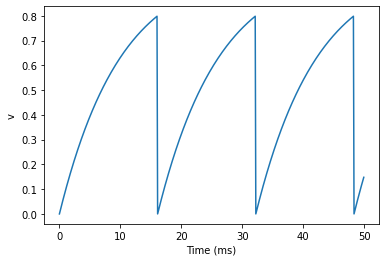

In [8]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(2, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

`StateMonitor` are 2D arrays with the index of the neuron, and the value of the timecourse.
This *should* lend itself to create tidy dataframes from this.
It can be done with the `get.states` syntax (requires pandas).

In [9]:
simdata = pd.DataFrame({
    'N': len(M.v),
    't': M.t,
    'V': M.v[0]})


This produces the output I want from this one, but is not quite what I want yet, we can go back to it.
Want to have a tidy format dataframe generated from a `StateMonitor` call that can handle multiple variables and neurons.
Should be doable with for loops.

Pseudocode:

* For each neuron in number_neurons
    - do a call to get states that produces a tidy output for that neuron
* then append these tidy frames to each other with a neuron index variable
* assign that to the main environment

Plotnine is the graphing library that should come close to functionaity to ggplot and has a tidy working paradigm.
Try to explore the tidy set created and make a line plot.

This should also be possible with np reshape commands.

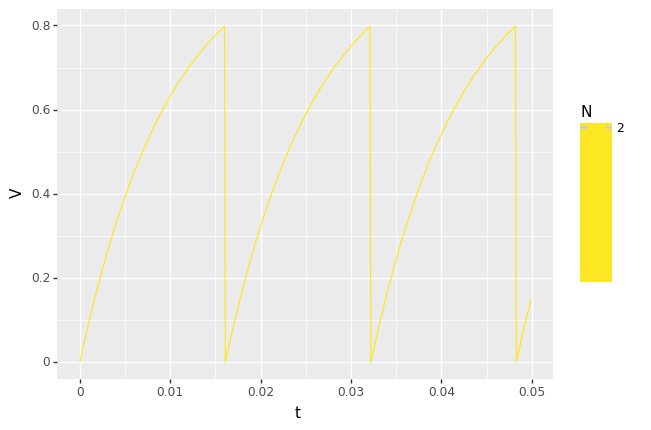

<ggplot: (8773402052139)>

In [10]:
(ggplot(simdata, aes(x = 't', y = 'V', colour = 'N'))
+ geom_line())

Brian can register spikes in the simulation.
This has been done by assigning the spike monitor command.

In [11]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.4', reset='v = 0.2', method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

# update the simdataframe 
simdata = pd.DataFrame({
    'N': len(statemon.v),
    't': statemon.t,
    'V': statemon.v[0]})

In [12]:
print('Spike times: %s' % spikemon.t[:])

Spike times: [ 5.1  8.  10.9 13.8 16.7 19.6 22.5 25.4 28.3 31.2 34.1 37.  39.9 42.8
 45.7 48.6] ms


In [13]:
spikesdf = pd.DataFrame({'spikes': spikemon.t/ms /1000})

Now we can plot the extracted spikes, on top of the timecourse.


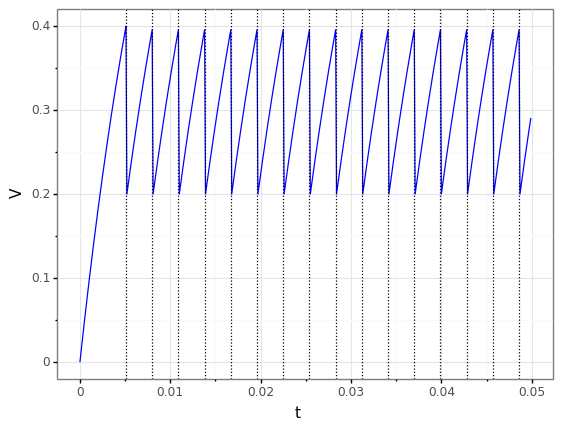

<ggplot: (8773401987676)>

In [14]:
(ggplot(simdata, aes(x = 't', y = 'V'))
+ geom_line(colour = 'blue')
+ geom_vline(aes(xintercept = 'spikes'), data = spikesdf, linetype = 'dotted')
+ theme_bw())

You can introduce refractoryness to the model by adding a refractory dead time.

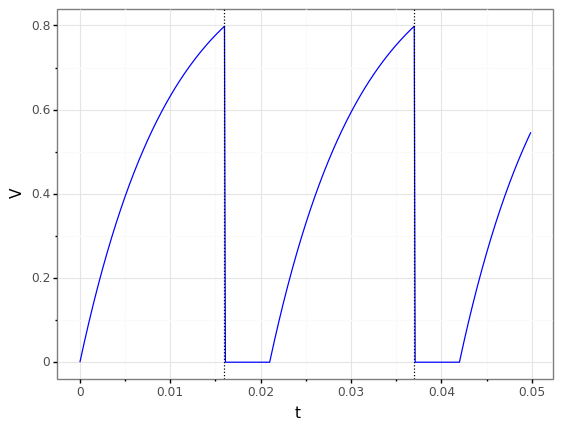

<ggplot: (-9223363263448933365)>

In [15]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

# The neuron with refractory time
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

# update the simdataframe 
simdata = pd.DataFrame({
    'N': len(statemon.v),
    't': statemon.t,
    'V': statemon.v[0]})

# update the spikes
spikesdf = pd.DataFrame({'spikes': spikemon.t/ms /1000})

# plot it
(ggplot(simdata, aes(x = 't', y = 'V'))
+ geom_line(colour = 'blue')
+ geom_vline(aes(xintercept = 'spikes'), data = spikesdf, linetype = 'dotted')
+ theme_bw())

What I did not like about the `plotnine` is that its ggpleot implementation seems to be very sensitive about types and spazzes out immediatly on that, whereas usually R will just throw a warning about continous vs other data.

Altair is another plotting library that looks very clean and is also ignorant about types.

In [16]:
import altair as alt

#tc plot
tc_chart = alt.Chart(simdata).mark_line().encode(
    x = 't:Q', 
    y = 'V:Q'  # Quantitative variable
)

#plot of the spike value with vertical line
spike_chart = alt.Chart(spikesdf).mark_rule(strokeDash=[5,5]).encode(
    x = 'spikes:Q'
)

# combine and print
alt.layer(tc_chart,spike_chart)

alt.LayerChart(...)

While not as straightforward as ggplot the syntax and output is simple and prety enough.

## Simulating multiple Neurons

Next are going to produce ouput for many neuron.

In [17]:
start_scope()
n_neurons = 100         # Number of neurons
tau = 10*ms             # time constant

# same equation as before but the asymtone is now 2
eqs = '''          
dv/dt = (2-v)/tau : 1 
''' 
# A network of 100 neurons
net_100 = NeuronGroup(n_neurons, eqs, threshold='v>1', reset='v=0', method='exact')
# this gives every neuron a different starting value for the voltage at t0
net_100.v = 'rand()' 

spikemon = SpikeMonitor(net_100) # this records the spiketimes

run(50*ms)


Now we need to clean the spikemonitor variable.
It contains variables `i` (neuron index) and `t` (spiketime).
They are arrays containing just one vector (dimension `(n_spikes,)`) and have the same length.
Tidying should therefore be easy.

There is a method implemented for `SpikeMonitor` objects that will return a dictionary object of the values, with the umber of the neuron as index.
Problem is it produces an array with a unit.

In [18]:
spikemon.all_values()['t'][0]

array([ 8.7, 36.7,  1.7, 29.7, 15.7, 43.7, 22.7]) * msecond

Despite this, pandas allows import, however, the data is now in wide format with the neuron as rows.
So we need to do some wrangling and pivoting.

In [19]:
spikes_wide = pd.DataFrame.\
from_dict(spikemon.all_values()['t'],
          orient = 'index')

# pandas for some reason loves rownames, which pisses me off coming from R
# we need to get the information stored in there!
spikes_wide.index.name = 'neuron'
spikes_wide.reset_index(inplace=True)

# pivot longer by neuron
spikes_long = spikes_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,8)),
                               var_name = 'spikeno',
                               value_name = 't')
# tidy and update the thing
spikes_long = spikes_long.sort_values(['neuron', 'spikeno'])
# drop NA values
spikes_long = spikes_long.dropna()
spikes_long

,neuron,spikeno,t
0,0,0,8.7 ms
100,0,1,36.7 ms
200,0,2,1.7 ms
300,0,3,29.7 ms
400,0,4,15.7 ms
...,...,...,...
299,99,2,2. ms
399,99,3,30. ms
499,99,4,44. ms
599,99,5,9. ms


This looks fine, but trying to wrangle more I got massive problems because the data types are rubbish.

In [20]:
spikes_long.dtypes

neuron      int64
spikeno    object
t          object
dtype: object

In [21]:
spikes_long['t'].str.split(expand = True)

,0
0,NaN
100,NaN
200,NaN
300,NaN
400,NaN
...,...
299,NaN
399,NaN
499,NaN
599,NaN


My plan was to treat the compound unt datatype as string and then extract the actual number.
That does not work and throws an error.
To get the number I need to apply the `/ms` syntax from the unit data type from brian.
That works only in a vectorised way if you have a numpy array.
Now it all lives in pandas.
We can do it on an individual datum though.


In [22]:
spikes_long['t'][1]


26.5 * msecond

In [23]:
spikes_long['t'][1]/ms


26.500000000000004

In [24]:
#vectorised is gets rid of something but not quite...
spikes_long['t']/ms

0       8.7 s
100    36.7 s
200     1.7 s
300    29.7 s
400    15.7 s
        ...  
299      2. s
399     30. s
499     44. s
599      9. s
699     23. s
Name: t, Length: 711, dtype: object

In [25]:
# try assiging a new column (mutate style in R)
spikes_long.assign(spiket = spikes_long['t'] /ms)

,neuron,spikeno,t,spiket
0,0,0,8.7 ms,8.7 s
100,0,1,36.7 ms,36.7 s
200,0,2,1.7 ms,1.7 s
300,0,3,29.7 ms,29.7 s
400,0,4,15.7 ms,15.7 s
...,...,...,...,...
299,99,2,2. ms,2. s
399,99,3,30. ms,30. s
499,99,4,44. ms,44. s
599,99,5,9. ms,9. s


It does not work, we need to do it row-wise!
Row-wise operations can be done with apply.

In [26]:
spikes_long['t'].apply(lambda x: x/ms)

0       8.7
100    36.7
200     1.7
300    29.7
400    15.7
       ... 
299     2.0
399    30.0
499    44.0
599     9.0
699    23.0
Name: t, Length: 711, dtype: float64

In [27]:
# do that in place
spikes_long['tnum'] = spikes_long['t'].apply(lambda x: x/ms)

Now we should be able to plot the spiketimes from the frame.


In [28]:
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 'tnum', y = 'neuron:Q')

alt.Chart(...)

Also altair lets us plot the thing even without transforming the type before as long as you specify that its a quantitative variable (`:Q` tag).

In [29]:
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 't:Q', y = 'neuron:Q')

alt.Chart(...)

## Parameters
We can systematically vary input parameter along neurons.

In [30]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

The line `v0 : 1` declares a new per-neuron parameter `v0` with units 1 (i.e. dimensionless) for the asymptote of the exponential.
The line `G.v0 = 'i*v0_max/(N-1)'` initialises the value of v0 for each neuron varying from 0 up to `v0_max`. The symbol `i` when it appears in strings like this refers to the neuron index.

In [31]:
# now we can run this and extract the spikes
run(duration)

In [32]:
spikes_wide = pd.DataFrame.\
from_dict(M.all_values()['t'],
          orient = 'index')

# pandas for some reason loves rownames, which pisses me off coming from R
# we need to get the information stored in there!
spikes_wide.index.name = 'neuron'
spikes_wide.reset_index(inplace=True)
# there will be now 1 neuron column with number of neuron rows
# and a column for each spike (as many columns as the maximum number of spikes for a neuron)
# there is an index column and a neuron column, so the max number of spikes
# and the number of data colums is the number of columns -2
spike_max = spikes_wide.shape[1]

# pivot longer by neuron
spikes_long = spikes_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,spike_max-1)),
                               var_name = 'spikeno',
                               value_name = 't')
# tidy and update the thing
spikes_long = spikes_long.sort_values(['neuron', 'spikeno'])
# drop NA values
spikes_long = spikes_long.dropna()
spikes_long['t'] = spikes_long['t'].apply(lambda x: x/ms)

In [108]:
# make this procedure into a function
def tidy_spike(s_mon_object) :
    """
    This function takes all the data from within a spikemonitor brian object
    and makes it into a tidy pandas frame
    """
    # extract the data to a wide frame
    sdata_wide =  pd.DataFrame.from_dict(s_mon_object.all_values()['t'],orient = 'index')
    sdata_wide.index.name = 'neuron'
    sdata_wide.reset_index(inplace=True)
    # there will be now 1 neuron column with number of neuron rows
    # and a column for each spike (as many columns as the maximum number of spikes for a neuron)
    # there is an index column and a neuron column, so the max number of spikes
    # and the number of data colums is the number of columns -2
    spike_max = sdata_wide.shape[1]
    
    # pivot longer by neuron
    sdata_long = sdata_wide.melt(id_vars = ('neuron'),
                               value_vars = list(range(0,spike_max-1)),
                               var_name = 'spikeno',
                               value_name = 't')
    
    # tidy and update the thing
    sdata_long = sdata_long.sort_values(['neuron', 'spikeno'])
    # drop NA values
    sdata_long = sdata_long.dropna()
    # add a proper numeric time variable
    sdata_long['t_ms'] = sdata_long['t'].apply(lambda x: x/ms)
    
    #return the thing
    return(sdata_long)  

In [109]:
# test the function
tidy_spike(M)

,neuron,spikeno,t,t_ms
18,18,0,0.4036 s,403.6
20,20,0,0.9031 s,903.1
120,20,1,125.5 ms,125.5
220,20,2,0.7287 s,728.7
21,21,0,74.2 ms,74.2
...,...,...,...,...
10799,99,107,203.1 ms,203.1
10899,99,108,0.6773 s,677.3
10999,99,109,192.8 ms,192.8
11099,99,110,230.3 ms,230.3


In [35]:
# now plot the thing
alt.Chart(spikes_long)\
.mark_point()\
.encode(x = 't:Q',
       y = 'neuron')


MaxRowsError: The number of rows in your dataset is greater than the maximum allowed (5000). For information on how to plot larger datasets in Altair, see the documentation

alt.Chart(...)

So apparently altair refuses to make plots with "large" datasets, which actually makes it utterly useless.

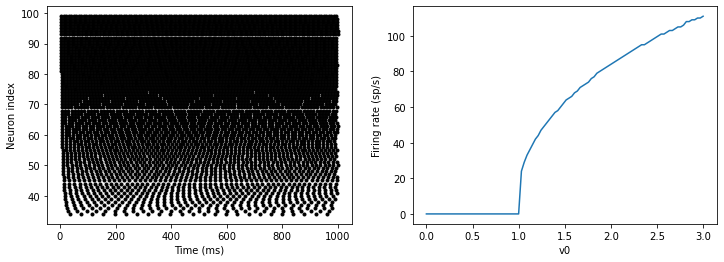

In [36]:
figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

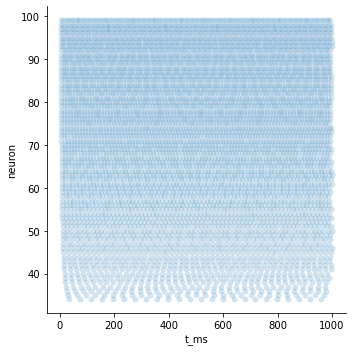

In [37]:
# try seaborn instead
import seaborn as sns

sns.relplot(x="t_ms", y="neuron", data=tidy_spike(M), alpha = 0.2);

Next, try to reproduce the plot from the example.
We will need to summarise by neuron to get the firing rate.
This should be possible with some group wise-pandas operation.
The syntax for this is `groupby` and `agg`. 

In [38]:
tidy_spike(M).groupby('neuron').agg({'spikeno': [max]})

,spikeno
,max
neuron,
34,23
35,28
36,32
37,35
38,38
...,...
95,108
96,108


This will give rubbish again because python indexes with 0.
In a world of meaningful numbers we need to add 1 to it to make it right.
After the summary we need to run some in-place mutation to add 1 to the the max spike.

In [39]:
summary_byN = tidy_spike(M).groupby('neuron').agg({'spikeno': [max]})
# add 1
summary_byN = summary_byN.assign(APMAX = summary_byN['spikeno']+1)
# calculate the firing rate (we simulated 1 second)
summary_byN = summary_byN.assign(FRate_hz = summary_byN['spikeno']/1)


Inspecting the code of the matplotlib stuff, there is actually by neuron summaries stored in the G and M objects.
Better try to write a tidier for those instead of re-inventing.

In [40]:
# firing counts
pd.Series({'A': np.array(M.count)})

A    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

Also `brian` has a method to extract the neuron parameters in pandas format to start.

In [41]:
# extracts all the model starting parameters and the last timepoint
summary_byN = G.get_states(units=False, format='pandas') 
# now we can assign the firing rate data as new columns
summary_byN['nAP'] = pd.Series(np.array(M.count))
# calculate firing rate
summary_byN = summary_byN.assign(FRate_hz = summary_byN['nAP']/1)
summary_byN

,N,i,t,dt,t_in_timesteps,v,lastspike,not_refractory,v0,nAP,FRate_hz
0,100,0,1.0,0.0001,10000,0.000000,-10000.0000,True,0.000000,0,0.0
1,100,1,1.0,0.0001,10000,0.030303,-10000.0000,True,0.030303,0,0.0
2,100,2,1.0,0.0001,10000,0.060606,-10000.0000,True,0.060606,0,0.0
3,100,3,1.0,0.0001,10000,0.090909,-10000.0000,True,0.090909,0,0.0
4,100,4,1.0,0.0001,10000,0.121212,-10000.0000,True,0.121212,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
95,100,95,1.0,0.0001,10000,0.000000,0.9978,False,2.878788,109,109.0
96,100,96,1.0,0.0001,10000,0.000000,0.9978,False,2.909091,109,109.0
97,100,97,1.0,0.0001,10000,0.000000,0.9960,False,2.939394,110,110.0
98,100,98,1.0,0.0001,10000,0.000000,0.9960,False,2.969697,110,110.0


Now we can plot the systematically varied parameter and the firing rate.

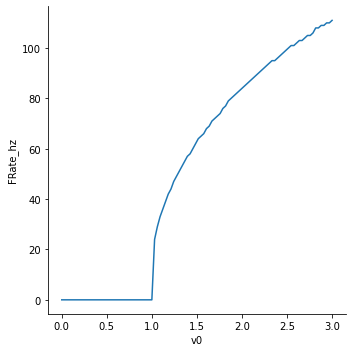

In [42]:
sns.relplot(x="v0", y="FRate_hz", data=summary_byN, kind = 'line');

To replicate what has been done in the example we need to set the plots side by side.
With seaborn that is done with matplotlib.
Seaborn is  a wrapper to matplotlib and creates plot objects compatible with it.

I had to change the options for plotting.
The previously used `relplot` is meant to produce larger facetted plots that you cant pass to make subplots apparently.

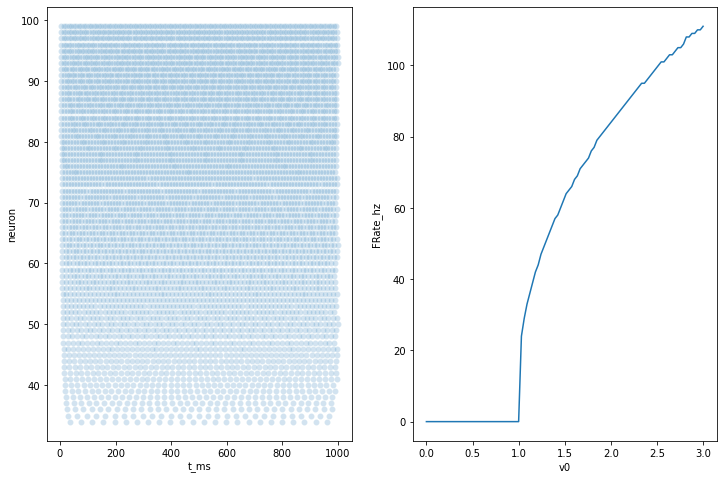

In [43]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.scatterplot(x="t_ms", y="neuron", data=tidy_spike(M), alpha = 0.2, ax=axes[0])
sns.lineplot(x="v0", y="FRate_hz", data=summary_byN, ax=axes[1]);

### Introducing a stochastic variable

In [121]:
start_scope()

N = 100
tau = 10*ms
v0_max = 1.
duration = 2000*ms
sigma = 0.4

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

Gnew = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
Mnew = SpikeMonitor(Gnew)

Gnew.v0 = 'i*v0_max/(N-1)'

run(duration)


This introduces a gaussian jitter on tau `sigma*xi*tau**-0.5`, why it takes this form exactly I dont know and is beyond me.

In [134]:
# Make a tidier for by neuron summaries
def tidy_byN(aneuron, monitorobj):
    """
    This function takes a brian neuron group
    and a spike monitor object of it
    then returns a tidy pandas frame of the start and and values and the firing rates
    """
    # extracts all the model starting parameters and the last timepoint
    byN = aneuron.get_states(units=False, format='pandas')
    
    # duration of the run
    run_dur = byN['t_in_timesteps'][0]*byN['dt'][0]
    # now we can assign the firing rate data as new columns
    byN['nAP'] = pd.Series(np.array(monitorobj.count))
    # calculate firing rate
    byN = byN.assign(FRate_hz = byN['nAP']/run_dur)
    return(byN)

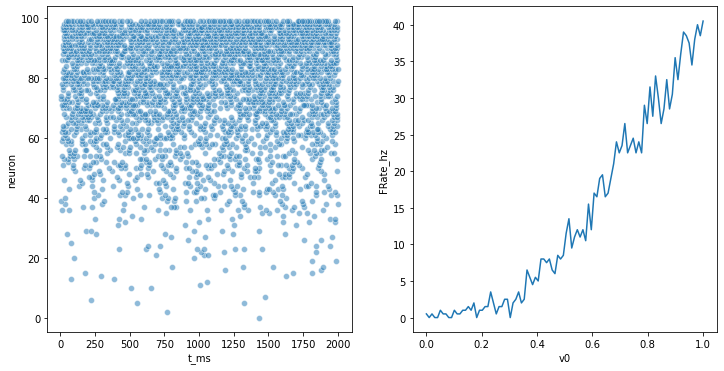

In [135]:
# now we can use both tidiers to quickly plot everything
f, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(x="v0", y="FRate_hz", data= tidy_byN(Gnew, Mnew), ax=axes[1])
sns.scatterplot(x = 't_ms', y = 'neuron', data = tidy_spike(Mnew), alpha = 0.5, ax=axes[0]);

# Synapses

In [225]:
start_scope()
del(tau)
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

Next section in the Manual:
We create 2 neurons.
For the parameters we can assign a vector of the length of the number of neurons.
We have different values for the asymtote as well as the time constant.
The First neuron should be exiteable spontaneously, the second not at all.

However, there is a synapse on the second on which will increase `v` on every spike of the first.
It should therefore fire after integrating a couple of spikes.

Now we will need a tidier for the V monitor object.
This may be a bit more complicated.
`monitor.v` is a 2 dimensional array.
There is a row for every Neuron.

In [226]:
np.array(M.v).shape

(2, 1000)

I dont know wnough about the arrays to see whether the following will fill the rows in the right way.
Got to try.

In [227]:
np.array(M.v).reshape(1000,2)

array([[0.        , 0.01990033],
       [0.03960265, 0.05910893],
       [0.07842112, 0.09754115],
       ...,
       [0.38110576, 0.38072484],
       [0.38034431, 0.37996416],
       [0.37958438, 0.37920499]])

This should be a rectangular table that pandas could handle.

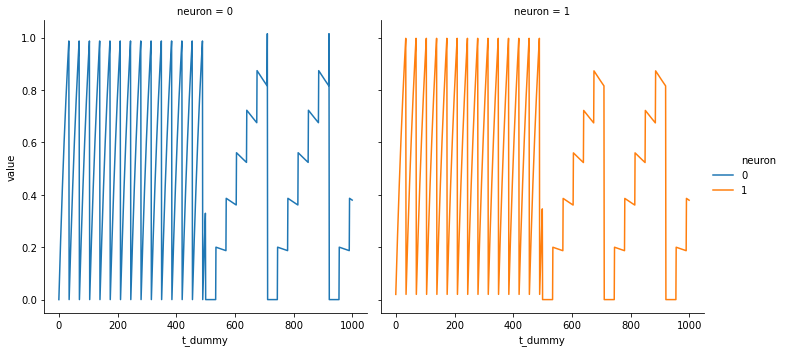

In [228]:
# If the following returns the time-series alright we are golden.
# reshape and make a frame
test = pd.DataFrame(np.array(M.v).reshape(1000,2))
test.index.name = 't_dummy'
test.reset_index(inplace=True)

# make long
test = test.melt(id_vars = 't_dummy', value_vars = [0, 1], var_name = "neuron")

sns.relplot(x = 't_dummy',
            y = 'value',
            hue = "neuron",
            col = "neuron",
            kind = "line",
            data = test);

It does not and the data from the `np.reshape` was just spread between the two columns.

In [290]:
# Its stored per row so we should be able to make a frame without reshaping
# reshape and make a frame
test = pd.DataFrame(np.array(M.v))
#test.index.name = 'neuron'
test.reset_index(inplace=True)
test

,index,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,0,0.0,0.0199,0.039603,0.059109,0.078421,0.097541,0.116471,0.135212,0.153767,...,0.190325,0.208332,0.226159,0.243809,0.261284,0.278584,0.295712,0.312670,0.329460,0.346082
1,1,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.382633,0.382251,0.381869,0.381487,0.381106,0.380725,0.380344,0.379964,0.379584,0.379205


In [284]:
# make long without t variable
test.melt(id_vars = 'index').rename(columns={'index': 'neuron'})


,neuron,variable,value
0,0,0,0.000000
1,1,0,0.000000
2,0,1,0.019900
3,1,1,0.000000
4,0,2,0.039603
...,...,...,...
1995,1,997,0.379964
1996,0,998,0.329460
1997,1,998,0.379584
1998,0,999,0.346082


In [350]:
# alternatively transpose, join time axis then melt
#start over with the wide one 
test = pd.DataFrame(np.array(M.v))
test = test.transpose()
test.index.name = 't_dummy'
test['t'] = pd.Series(np.array(M.t))

# this does the job
test = pd.melt(test,
               value_vars = [0,1],
               id_vars = ['t'],
               var_name = "neuron",
               value_name = 'v')

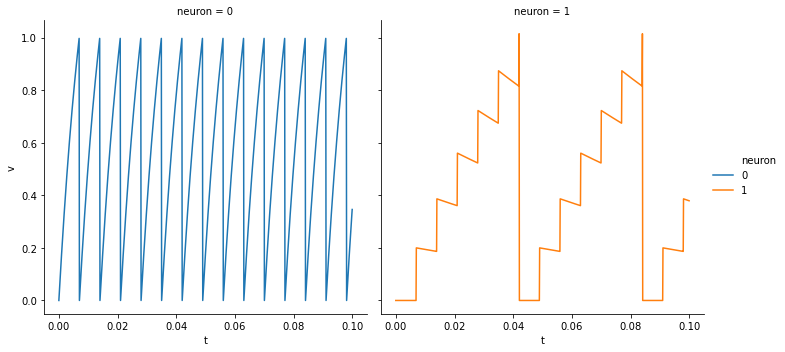

In [351]:
sns.relplot(x = 't',
            y = 'v',
            hue = "neuron",
            col = "neuron",
            kind = "line",
            data = test);

Again we want to have a tidier for this kind of thing.

In [348]:
# you cant use .v something as a wildcard..unfortunately
# so this function can just deal with monitors of v
def tidy_v(ts_statemon):
    '''
    Function that will return a tidy timeseries dataframe
    from a brian StateMon object.
    '''
    # start over with a wide frame
    ts_frame = pd.DataFrame(ts_statemon.v)
    
    # the number of rows is the number of neurons
    n_neuron = ts_statemon.v.shape[0]
    
    # make long with 1 Neuron as 1 column
    ts_frame = ts_frame.transpose()
    # add the time axis
    ts_frame.index.name = 't_dummy'
    ts_frame['t'] = pd.Series(np.array(ts_statemon.t))
    # this does the job
    return(pd.melt(ts_frame,
                   value_vars = list(range(0, n_neuron)),
                   id_vars = ['t'],
                   var_name = "neuron",
                   value_name = 'v'))

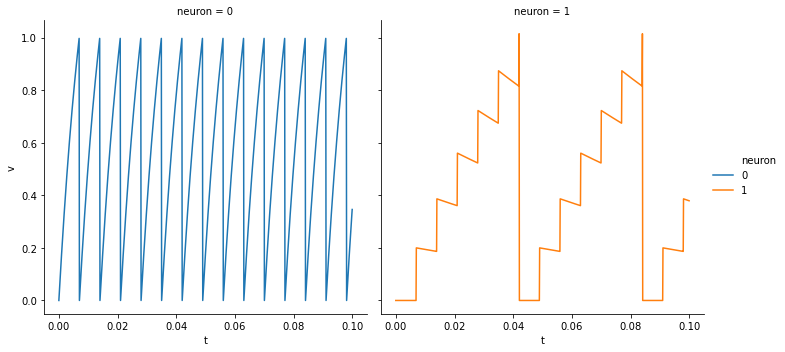

In [349]:
# test the function
sns.relplot(x = 't',
            y = 'v',
            hue = "neuron",
            col = "neuron",
            kind = "line",
            data = tidy_v(M));

More Synapses, next we introduce synapses of different strength.

In [352]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0] # One neuron that fires, asymtote of 0 for the others means no spontaneous firing
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2' # 'synaptic weight'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

The 3rd, new neuron makes bigger steop increases as the presynaptic neuron fires.

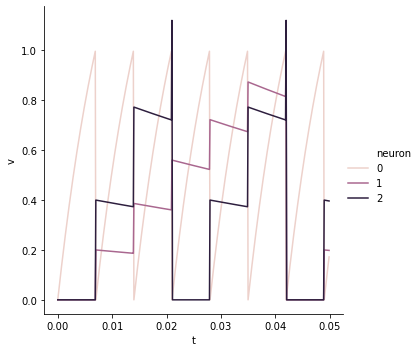

In [354]:
sns.relplot(x = 't',
            y = 'v',
            hue = "neuron",
            #col = "neuron",
            kind = "line",
            data = tidy_v(M));

Synapses also have a delay parameter that tell you how fast the signal appears from the 'soma' of the firing cell to a postsynaptic event on the next neuron.

In [357]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

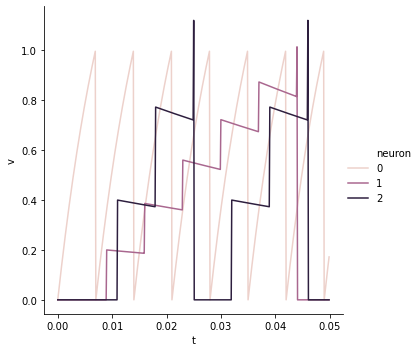

In [358]:
sns.relplot(x = 't',
            y = 'v',
            hue = "neuron",
            #col = "neuron",
            kind = "line",
            data = tidy_v(M));

## Connectivity
I will not study this one at grat length.
Mostly I just want to do soma models with HH formulations.

In [359]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

The formulation for the connections is assigned with the `connect` method and concerns pairs of neuon indexes `i` and `j`.
Here theu will be connected with probability `p = 0.2` as long as `i` is not `j`. 

This is the wrapper function to make diagrams of the $i j$ connectivity matrix.
I will not bother to re-cook this one in a tidy way.

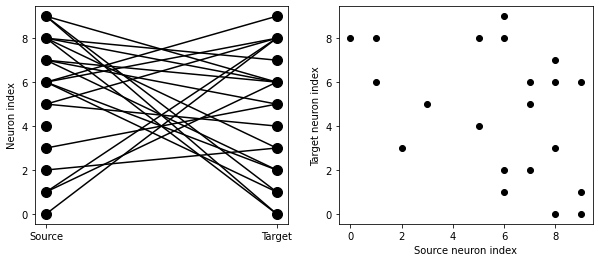

In [360]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

Skip the more complicated connectivity tutorials

# Simulations

We now go for the standard task of running multiple simulations with a network that is systematically varied.
(this might not be needed for varying neurons, as you can use the parameter options...)

Here we have a network that is driven by a random process.
The neurons have an asymptote of 0 here and can only fire from the input.
There is only one neuron with 100 inputs.

Now we have the question how that neurons oupput (in terms of firing rate) changes depending on different values for $\tau$.

In [364]:
# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(tidy_byN(G, M))
    

Now we need to concatenate the list of dataframes to one and plot the thing.
We can concatenate lists of tidy pandas frame with the `pd.concat` method as long as they share their format.


In [368]:
# this concatenates it
pd.concat(output_rates)
# also need to add a column for the tau values, probably best to find a way to add it during the loop...
output_rates = pd.concat(output_rates)
output_rates['tau'] = linspace(1, 10, 30)

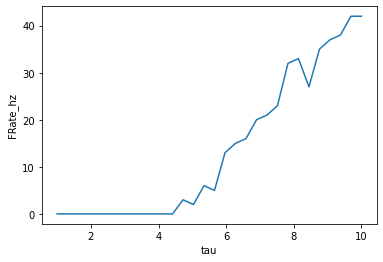

In [369]:
# Plot it
sns.lineplot(x = 'tau', y = 'FRate_hz', data = output_rates);

The performance (ie speed) can be much improoved by using the `store` states commands.
Instead of re creating the neurons every loop, we set the nurons up once and then run the simulations from this basis.

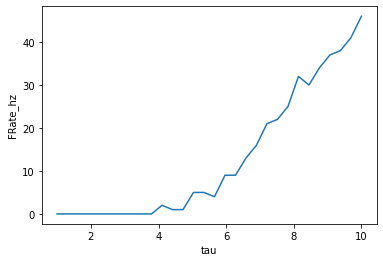

In [373]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)

# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(tidy_byN(G,M))
# concatenate and plot it
output_rates = pd.concat(output_rates)
output_rates['tau'] = linspace(1, 10, 30)
# Plot it
sns.lineplot(x = 'tau', y = 'FRate_hz', data = output_rates);

The store and restore commands can be used in more complicated situations.
For example you can "fork" a simulation to different conditions after running and stroting it.

Int he following a spike pattern is generated, stored and played to a number of different neurons.

In order not to re-run all the objects created (spike generator and neurons), special syntax assigning network groups are used.
Then, only one network can be run.

In [378]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t

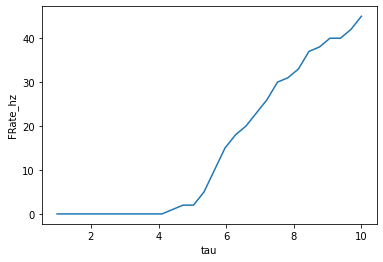

In [379]:
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(tidy_byN(G,M))
# concatenate and plot it
output_rates = pd.concat(output_rates)
output_rates['tau'] = linspace(1, 10, 30)
# Plot it
sns.lineplot(x = 'tau', y = 'FRate_hz', data = output_rates);

Also, (and I find this more intuitive) we only have on neuron in the network.
Instead of looping we can just assign tau as a parameter and play the recorded spikes.
Pay attention to how this is done, as likely I would construct such models with only one neuron but parameters! 

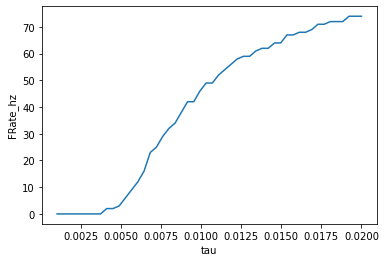

In [383]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# specify tau, do note that this also assigns the number of neurons!
tau_range = linspace(1, 20, 50)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = tidy_byN(G,M) # firing rate is count/duration

# no need to concatenate anything as tau should be written in the starting condition per neuron.
sns.lineplot(x = 'tau', y = 'FRate_hz', data = output_rates);

## getting to HH...
The following code now uses a simple HH model.
It shows how to manipulate input voltages and the like.
The task at hand is to stimulate regularly but change the amplitude of the injected current every 10ms.
Such operations can be done with the `run_regularly` method of the neuron group.
Here, regularly, every 10 ms the injecting current is changed randomly.

In [424]:
start_scope()
# Parameters
area = 20000*umetre**2              # Membrane area
Cm = 1*ufarad*cm**-2 * area         # capacitance per area
gl = 5e-5*siemens*cm**-2 * area     # leak conductance per area
El = -65*mV                         # leak reversal (RMP)
EK = -90*mV                         # potassium reversal
ENa = 50*mV                         # sodium reversal
g_na = 100*msiemens*cm**-2 * area   # Na conductance per area
g_kd = 30*msiemens*cm**-2 * area    # K conductance per area 
VT = -63*mV                         # nernst slope
# The model
eqs_HH = '''
# voltage equation
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt

# Sodium activation particle (Po)
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
    
# Potassium activation particle
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
    
# Sodium inactivation particle
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''

group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)

''

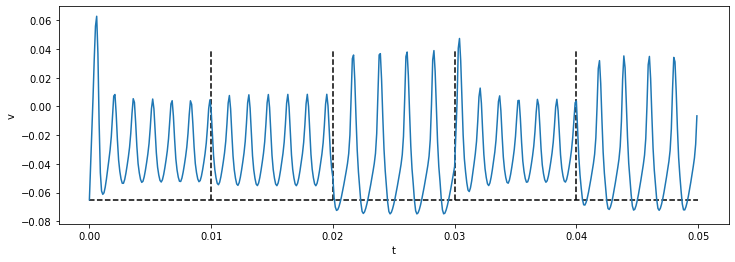

In [425]:
# specify wide figure aspect ratio for time series plot
figure(figsize=(12, 4))
sns.lineplot(x = 't', y = 'v', data = tidy_v(statemon))
# vlines adds multiple vertical lines in a vectorised way
plt.vlines(array([0.01, 0.02, 0.03, 0.04]),
           ymin = -0.065,
           ymax = 0.04,
           linestyles = 'dashed')
plt.hlines(-0.065,
           xmin = 0,
           xmax = 0.05,
           linestyles = 'dashed')
;

Alternatively, and allowing more complexity `network operations` can be specified.
Here any code can be run, here we use the `I` attribute of the neuron to set the stimulation again.

''

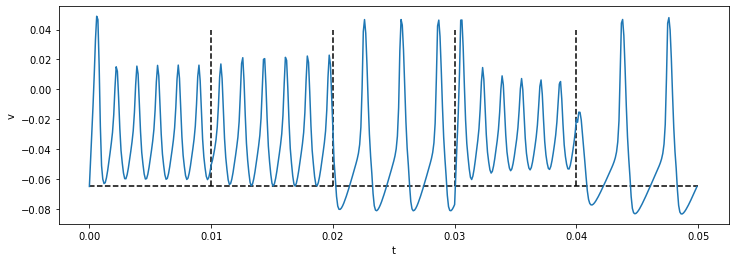

In [426]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

# we replace the loop with a network_operation
@network_operation(dt=10*ms)
def change_I():
    group.I = rand()*50*nA
    
run(50*ms)

# specify wide figure aspect ratio for time series plot
figure(figsize=(12, 4))
sns.lineplot(x = 't', y = 'v', data = tidy_v(statemon))
# vlines adds multiple vertical lines in a vectorised way
plt.vlines(array([0.01, 0.02, 0.03, 0.04]),
           ymin = -0.065,
           ymax = 0.04,
           linestyles = 'dashed')
plt.hlines(-0.065,
           xmin = 0,
           xmax = 0.05,
           linestyles = 'dashed')
;

Next, we use multiple neurons to simulate the same inputs.
We use a neuron group with the capacitance as parameter (ie the neurons will have different sizes).

''

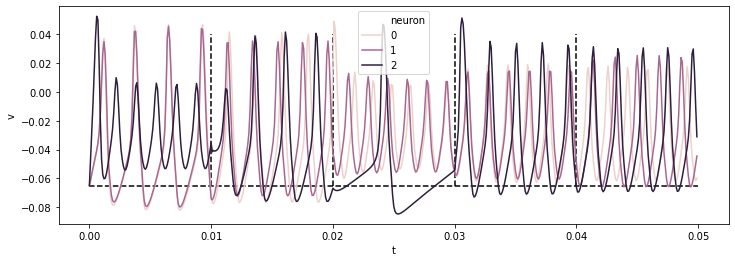

In [430]:
start_scope()
N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)

# Plot
figure(figsize=(12, 4))
sns.lineplot(x = 't',
             y = 'v',
             hue = 'neuron',
             data = tidy_v(statemon))
# vlines adds multiple vertical lines in a vectorised way
plt.vlines(array([0.01, 0.02, 0.03, 0.04]),
           ymin = -0.065,
           ymax = 0.04,
           linestyles = 'dashed')
plt.hlines(-0.065,
           xmin = 0,
           xmax = 0.05,
           linestyles = 'dashed')
;

Here, all neuons received a different random input.
In order to compare the effect of the capacitance we need to do something else!
In order for each neuron to receive the same input on the `rand` current command, we need to set `I` as shared in the equation setup.

''

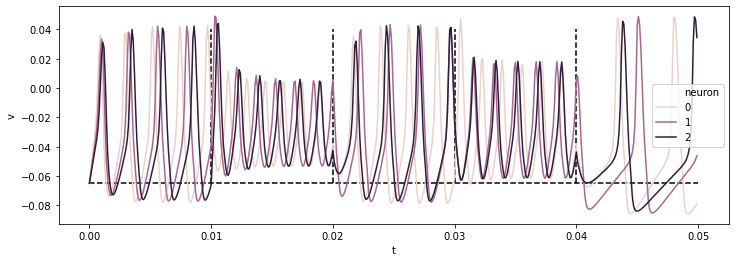

In [431]:
start_scope()
N = 3
eqs_HH_3 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared) # everything is the same except we've added this shared
C : farad
'''
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)

# Plot
figure(figsize=(12, 4))
sns.lineplot(x = 't',
             y = 'v',
             hue = 'neuron',
             data = tidy_v(statemon))
# vlines adds multiple vertical lines in a vectorised way
plt.vlines(array([0.01, 0.02, 0.03, 0.04]),
           ymin = -0.065,
           ymax = 0.04,
           linestyles = 'dashed')
plt.hlines(-0.065,
           xmin = 0,
           xmax = 0.05,
           linestyles = 'dashed')
;

Because of the different time it takes to charge the capacitator there is a phase delay.
The system does not equlibrate in 10 ms and the "slowest" neuron sometimes fires before the "quicker" one after the input had changed.
Try running a longer stretch.
For longer chunks of recordings the black trace should always fire last if equilibrated, no?

In [437]:
start_scope()
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
group.run_regularly('I = rand()*50*nA', dt=30*ms)
run(150*ms)

In [479]:
# Plot
capdata = tidy_v(statemon)
# slice the data for the different stimulation intervals
capdata['stim'] = pd.cut(capdata['t'],5) 
# last add a per-sweep time axis
# there are 4500 datapoints and 3x5 sweeps, 30ms per sweep
# np tile allows you to stack a series on top each other
# np arrange creates a range
capdata['t_sweep'] = tile(np.arange(0,30,30/300),15)

<Figure size 1728x576 with 0 Axes>

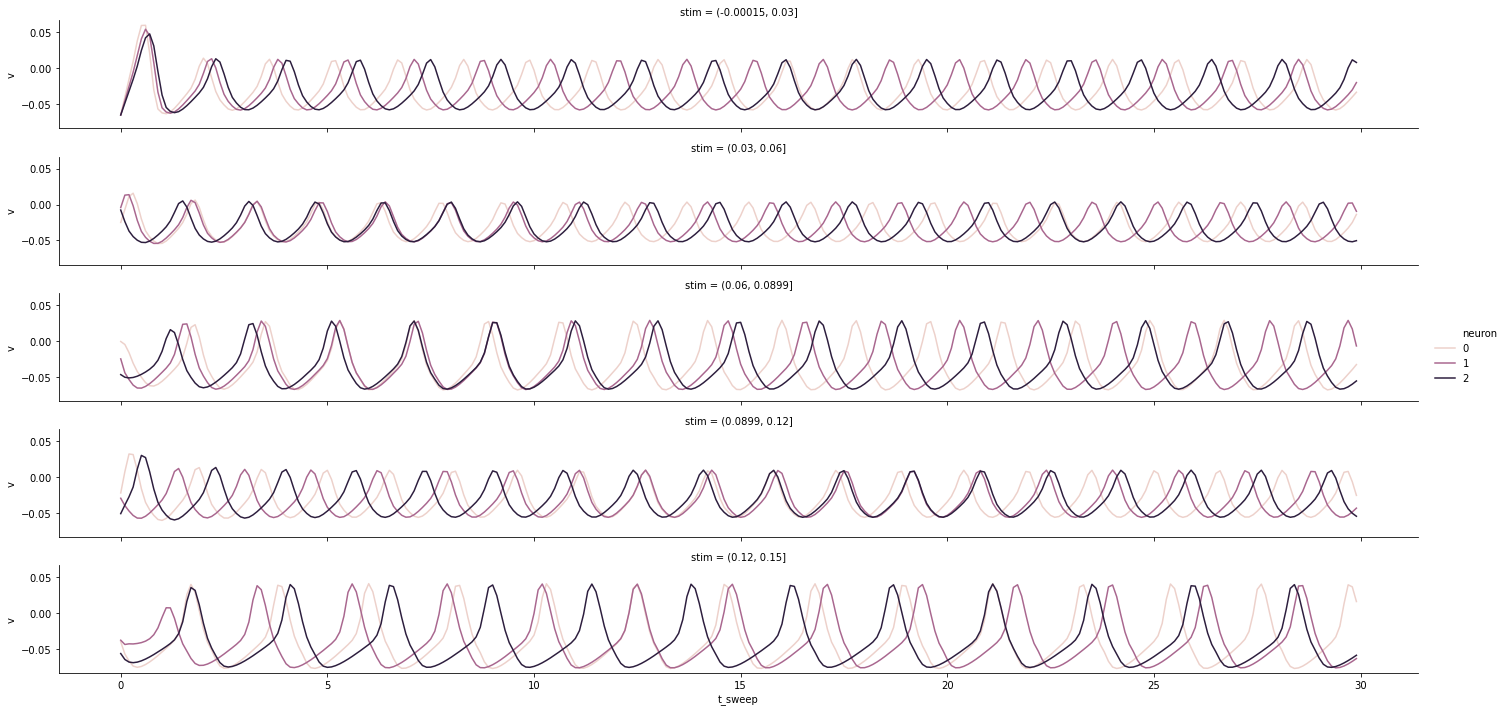

In [484]:
figure(figsize=(24, 8))
sns.relplot(x = 't_sweep',
            y = 'v',
            kind = 'line',
            hue = 'neuron',
            height = 2,
            aspect = 10,
            row = 'stim',
            data = capdata);

This is not like a protocol as the stimulation starts sequentially with different delays already in place.
Try to run again with a for loop.

In [596]:
start_scope()
agroup = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
agroup.v = El
agroup.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
astatemon = StateMonitor(agroup, 'v', record=True)

capresult = []
Istim = [24,50,400]*nA

# Store the current state of the network
cap = Network(agroup, astatemon)
cap.store()

for I in Istim:
    # restore the system
    #cap.restore()
    # Run it with the new value of tau
    cap.run(1000*ms)
    runresult = tidy_v(astatemon)
    # write the stimulation current
    runresult['I_stim'] = [I/amp] * len(runresult['v'])
    runresult['t_stim'] = tile(np.arange(0,
                                         1,
                                         1/len(runresult['v'])*3),
                               3) # need to add n neurons here
    capresult.append(runresult)


WARNING    "I" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 24. * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 0.4 * uamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [597]:
#tidy and plot
capresult = pd.concat(capresult)

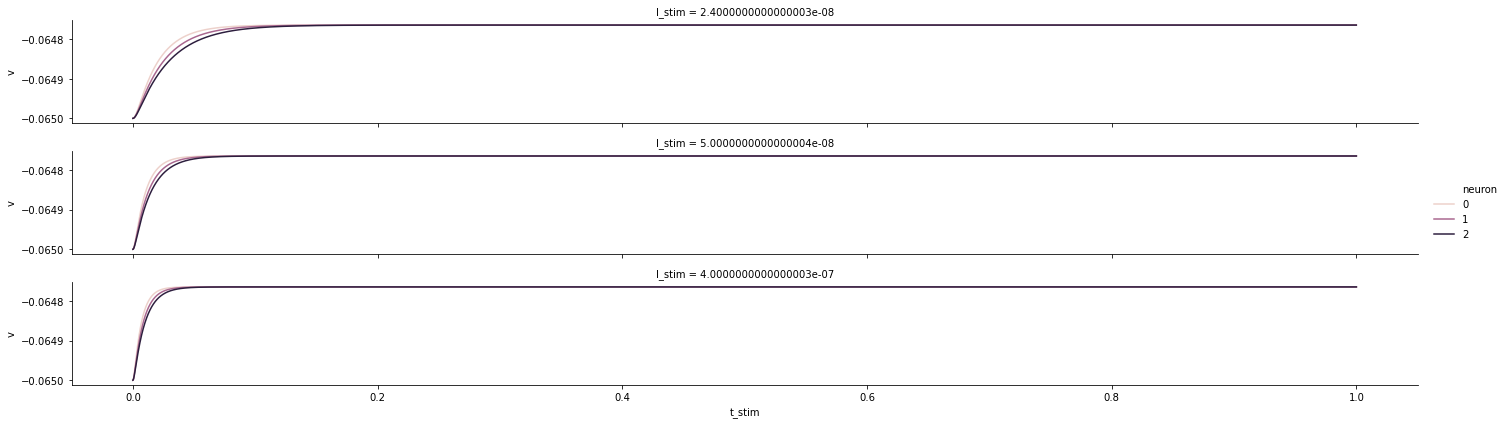

In [598]:
sns.relplot(x = 't_stim',
            y = 'v',
            kind = 'line',
            hue = 'neuron',
            height = 2,
            aspect = 10,
            row = 'I_stim',
            data = capresult)

it does seem to work but the membrane is not exciteable... some parameters must be off.
I think it has to do with assigning I in the beggining with the equations.

WARNING    "I" is an internal variable of group "neurongroup_13", but also exists in the run namespace with the value 0.4 * uamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


''

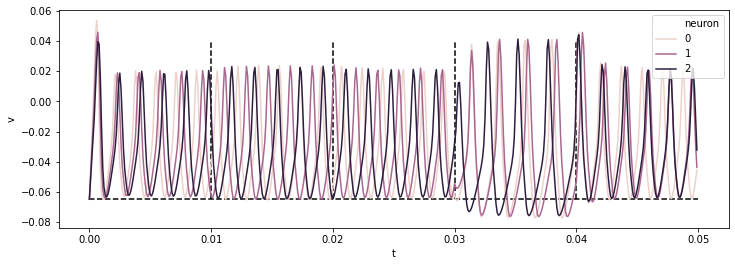